# Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, accuracy_score
from sklearn.inspection import permutation_importance
import ta
from xgboost import XGBClassifier

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
from pprint import pprint

import gc
import optuna
from sklearn.feature_selection import RFE

In [2]:
df = pd.read_csv('Data/Training/exploration_190pairs_300_20.csv')
df.head()

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,corr_coef_l15,corr_coef_l20,corr_coef_l40,corr_coef_l60,pnls,num_entries,days_till_first_entry,both_legs_profited,SPY_return,successful_pair_trading
0,2015-01-02,ADBE,72.340,GOOG,26.169,73.200,26.491,71.890,26.133,2349200.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.709,False
1,2015-01-05,ADBE,71.980,GOOG,25.623,72.430,26.145,71.570,25.583,2403300.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.547,False
2,2015-01-06,ADBE,70.530,GOOG,25.029,72.100,25.738,69.880,24.984,2895400.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.122,False
3,2015-01-07,ADBE,71.110,GOOG,24.986,71.290,25.293,70.420,24.914,2378300.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.883,False
4,2015-01-08,ADBE,72.920,GOOG,25.065,73.060,25.105,71.310,24.483,2624200.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.170,False


In [3]:
total_days = df.Date.nunique()
total_days

1257

In [4]:
print(df.shape)
df.isna().sum()

(238830, 38)


Date                              0
Ticker_P1                         0
Close_P1                          0
Ticker_P2                         0
Close_P2                          0
High_P1                           0
High_P2                           0
Low_P1                            0
Low_P2                            0
Volume_P1                         0
Volume_P2                         0
abs_spread                        0
same_sector_flag                  0
same_sub_industry_flag            0
abs_spread_mean               56810
abs_spread_std                56810
abs_spread_mean_l20            3610
abs_spread_std_l20             3610
spread_normed                 56810
abs_spread_normed_max        113620
abs_spread_normed_90th       113620
abs_spread_normed_75th       113620
abs_spread_normed_median     113620
abs_spread_normed_l7_avg      57950
abs_spread_normed_l14_avg     59280
cos_sim                       56810
corr_coef_l5                    760
corr_coef_l10               

In [5]:
df.Date.nunique()

1257

In [6]:
df.abs_spread_normed_max.dropna().describe()

count   125210.000
mean         3.171
std          0.687
min          1.364
25%          2.710
50%          3.082
75%          3.562
max          6.698
Name: abs_spread_normed_max, dtype: float64

In [7]:
df = df.sort_values('Date')

In [8]:
print(df.Date.min(),df.Date.max())

2015-01-02 2019-12-30


# Feature Engineering

In [9]:
# TODO:
# 1. Add group based features
# 2. Stock2Vec based features
# 3. Add Technical Indicators
# 4. target is a sum of 2 directions with magnitudes (how much it goes up/down per leg)
# 5. rolling features
# 6. probability of classification model
# 7. historical pnl and num_entries, drop leaky num_entries
# 8. differencing features.

In [10]:
# 3 dimensions from a product perspective: ticker1, ticker2, and pair
# 2 dimensions from a time perspective: short term vs long term
# 2 factors of PnL: Volatility, and Reversion to mean

# short term ticker 1 volatility: rolling mean, sector rolling mean, rolling std, sector rolling std
# short term ticker 2 volatility: rolling mean, sector rolling mean, rolling std, sector rolling std
# short term pair level volatility: rolling mean, sector rolling mean, rolling std, sector rolling std, 
#                                   differences of ticker level features

# long term ticker 1 volatility: beta,
# long term ticker 2 volatility: beta,
# long term pair level volatility: most recent PNL (which is from 120 days ago), average historical PNL
#                                  most recent number of entries, historical average vnumber of entries, 
#                                  diff of beta

# short term ticker 1 reversion to mean: technical indicators
# short term ticker 2 reversion to mean: technical indicators
# short term pair level reversion to mean: technical indicators

# long term ticker 1 reversion to mean: technical indicators
# long term ticker 2 reversion to mean: technical indicators
# long term pair level reversion to mean: technical indicators

## Technical Indicators

In [11]:
class feature_engineering(object):
    def __init__(self):
        super(feature_engineering, self).__init__()

    def generate_technical_indicator(self, data_df): 
        '''
        Function to generate additional technical indicators for the stock

        Uses the "statsmodels.tsa.stattools" (as "ts") package to apply 
        the equations specified in the "Technical Indicators" markdown section 
        to stock closing data.
        
        Input:
        data_df-- Dataframe containing stock finacials data
        
        Output:
        Stock finacials data with added Dataframe of feature obtained from feature engineering
        ''' 
        # 1. Momentum Indicators
        # Relative Strength Index
        df = data_df
        df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
        # Kaufman’s Adaptive Moving Average (KAMA)
        df['kama'] = ta.momentum.kama(df['Close'],window=14)

        # 2. Volume Indicators
        # Accumulation/Distribution Index (ADI)
        df['adi'] = ta.volume.acc_dist_index(df['High'], df['Low'], df['Close'], df['Volume'])

        # Volume-price trend (VPT)
        df['vpt'] = ta.volume.volume_price_trend(df['Close'], df['Volume'])

        # 3. Volatility Indicators
        # Average True Range (ATR)
        df['atr'] = ta.volatility.average_true_range(df['High'], df['Low'],df['Close'], window=14)

        # Bollinger Bands (BB) N-period simple moving average (MA)
        df['bb_ma'] = ta.volatility.bollinger_mavg(df['Close'], window=20)

        # 4. Trend Indicators
        # Average Directional Movement Index (ADX)
        df['adx'] = ta.trend.adx(df['High'], df['Low'], df['Close'], window=14)

        # Exponential Moving Average
        df['ema'] = ta.trend.ema_indicator(df['Close'], window=14)

        # Moving Average Convergence Divergence (MACD)
        df['macd'] = ta.trend.macd(df['Close'], window_fast=14, window_slow=30)

        # 5. Other Indicators
        # Daily Log Return (DLR)
        df['dlr'] = ta.others.daily_log_return(df['Close'])

        # Daily Returns
        df['daily_returns'] = df['Close'].pct_change()

        # Moving Averages
        averages = [50,200]
        for avg in averages:
            col_name = str(avg) +' Days Average'
            df[col_name] = df['Close'].rolling(window = avg, center = False).mean()

        return df

### Load SPY

In [12]:
spy_df = pd.read_csv('Data/Training/1999-12-01-2023-12-31_SPY.csv')
spy_df = spy_df[['Date','Adj Close']]
spy_df.columns = ['Date','SPY_Close']
df = pd.merge(df,spy_df,on='Date',how='left')

### Beta

In [13]:
def compute_beta(rs,df,ticker,market):
    rows = df.loc[rs.index]
    sec_returns = np.log( df[[ticker,market]] / df[[ticker,market]].shift(1) ) 

    cov = sec_returns.cov() * 250
    cov_with_market = cov.iloc[0,1]
    market_var = sec_returns[market].var() * 250
    beta = cov_with_market / market_var
    return beta

In [14]:
all_tickers = df['Ticker_P1'].unique().tolist()+df['Ticker_P2'].unique().tolist()
len(all_tickers)

38

In [15]:
fe_obj = feature_engineering()


### Single Ticker Features

In [16]:
df.columns

Index(['Date', 'Ticker_P1', 'Close_P1', 'Ticker_P2', 'Close_P2', 'High_P1',
       'High_P2', 'Low_P1', 'Low_P2', 'Volume_P1', 'Volume_P2', 'abs_spread',
       'same_sector_flag', 'same_sub_industry_flag', 'abs_spread_mean',
       'abs_spread_std', 'abs_spread_mean_l20', 'abs_spread_std_l20',
       'spread_normed', 'abs_spread_normed_max', 'abs_spread_normed_90th',
       'abs_spread_normed_75th', 'abs_spread_normed_median',
       'abs_spread_normed_l7_avg', 'abs_spread_normed_l14_avg', 'cos_sim',
       'corr_coef_l5', 'corr_coef_l10', 'corr_coef_l15', 'corr_coef_l20',
       'corr_coef_l40', 'corr_coef_l60', 'pnls', 'num_entries',
       'days_till_first_entry', 'both_legs_profited', 'SPY_return',
       'successful_pair_trading', 'SPY_Close'],
      dtype='object')

In [17]:
all_tickers_df_list = []
for t in tqdm(all_tickers):
    single_ticker_df = (df[df['Ticker_P1']==t] if t in df['Ticker_P1'].unique() else df[df['Ticker_P2']==t])
    single_ticker_df = single_ticker_df.sort_values('Date')
    single_ticker_df = single_ticker_df[['Date','Ticker_P1','Close_P1','High_P1','Low_P1','Volume_P1','SPY_Close']] if t in df['Ticker_P1'].unique() else\
                       single_ticker_df[['Date','Ticker_P2','Close_P2','High_P2','Low_P2','Volume_P2','SPY_Close']]
    single_ticker_df.columns = ['Date','Ticker','Close','High','Low','Volume','SPY_Close']
    single_ticker_df = single_ticker_df.drop_duplicates()

    single_ticker_df['rolling_beta'] = single_ticker_df['Close'].rolling(300).progress_apply(compute_beta, \
                                        args=(single_ticker_df,'Close','SPY_Close'))

    single_ticker_df_with_technical_indicators = fe_obj.generate_technical_indicator(single_ticker_df)

    all_tickers_df_list.append(single_ticker_df_with_technical_indicators)


  0%|          | 0/38 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [18]:
all_tickers_df = pd.concat(all_tickers_df_list,axis=0,ignore_index=True).reset_index(drop=True)
all_tickers_df.shape

(47766, 21)

In [19]:
df = df.reset_index(drop=True)

In [20]:
df.tail(2)

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,corr_coef_l20,corr_coef_l40,corr_coef_l60,pnls,num_entries,days_till_first_entry,both_legs_profited,SPY_return,successful_pair_trading,SPY_Close
238828,2019-12-30,DTE,96.022,LYV,71.210,109.821,71.920,109.081,70.780,1603170.000,...,-0.017,0.413,0.389,NaN,NaN,NaN,NaN,1.725,False,301.500
238829,2019-12-30,WELL,69.997,ZBRA,254.110,81.040,256.710,80.290,253.730,2517700.000,...,-0.410,-0.594,-0.868,NaN,NaN,NaN,NaN,1.725,False,301.500


In [21]:
all_tickers_df.tail(2)

,Date,Ticker,Close,High,Low,Volume,SPY_Close,rolling_beta,rsi,kama,...,vpt,atr,bb_ma,adx,ema,macd,dlr,daily_returns,50 Days Average,200 Days Average
47764,2019-12-27,STZ,177.927,190.570,188.870,568600.000,303.171,0.720,58.591,173.964,...,-1621571.095,12.684,173.521,20.210,174.909,0.133,-0.227,-0.002,175.804,181.012
47765,2019-12-30,STZ,177.119,189.370,187.800,901000.000,301.500,0.720,56.220,174.248,...,-1625665.705,12.595,173.629,19.440,175.203,0.277,-0.455,-0.005,175.651,181.105


In [22]:
print(df.shape)
all_tickers_df_P1_suffix = all_tickers_df.copy()
all_tickers_df_P1_suffix.columns = ['Date','Ticker']+[c+'_P1' for c in all_tickers_df.columns if c not in ['Date','Ticker']]
all_tickers_df_P2_suffix = all_tickers_df.copy()
all_tickers_df_P2_suffix.columns = ['Date','Ticker']+[c+'_P2' for c in all_tickers_df.columns if c not in ['Date','Ticker']]

df = pd.merge(df,all_tickers_df_P1_suffix,left_on=['Date','Ticker_P1'],right_on=['Date','Ticker'],\
              how='left',suffixes=['','_P1']).drop_duplicates()
print(df.shape)
df = pd.merge(df,all_tickers_df_P2_suffix,left_on=['Date','Ticker_P2'],right_on=['Date','Ticker'],\
              how='left',suffixes=['','_P2']).drop_duplicates()
print(df.shape)
df = df.loc[:,~df.columns.duplicated()]
print(df.shape)


(238830, 39)
(238830, 59)
(238830, 79)
(238830, 78)


In [23]:
del all_tickers_df_P1_suffix, all_tickers_df_P2_suffix
gc.collect()

204

In [24]:
df = df.drop('Ticker',axis=1)

### Prev Values

In [25]:
df = df.sort_values('Date')

In [26]:
df['PREV_num_entries'] = df.groupby(['Ticker_P1','Ticker_P2']).num_entries.shift(21)
df['PREV_pnls'] = df.groupby(['Ticker_P1','Ticker_P2']).pnls.shift(21)

# Trim head and tail days

In [27]:
print(df.shape)
df = df.drop(df.groupby(['Ticker_P1','Ticker_P2']).head(301).index,axis=0)
print(df.shape)
df = df.drop(df.groupby(['Ticker_P1','Ticker_P2']).tail(21).index,axis=0)
print(df.shape)

(238830, 79)
(181640, 79)
(177650, 79)


### Diff Values

In [28]:
for c in ['Close', 'High', 'Low', 'Volume', 'rolling_beta', 'rsi', 'kama',
       'adi', 'vpt', 'atr', 'bb_ma', 'adx', 'ema', 'macd', 'dlr',
       'daily_returns', '50 Days Average', '200 Days Average']:
# ,
#        'sector_rolling_beta_mean', 'sector_rolling_beta_std',
#        'sector_daily_return_mean', 'sector_daily_return_std']:
    df['DIFF_'+c] = df[c+'_P1'] - df[c+'_P2']

In [29]:
df['DIFF_abs_spread_mean_l20_500'] = df['abs_spread_mean_l20'] - df['abs_spread_mean']

In [30]:
df.isna().sum().sort_values(ascending=False).head(20)

days_till_first_entry        68952
abs_spread_normed_median     56430
abs_spread_normed_75th       56430
abs_spread_normed_90th       56430
abs_spread_normed_max        56430
PREV_pnls                     3800
PREV_num_entries              3800
abs_spread_normed_l14_avg     2090
abs_spread_normed_l7_avg       760
atr_P2                           0
macd_P2                          0
ema_P2                           0
adx_P2                           0
bb_ma_P2                         0
vpt_P2                           0
daily_returns_P2                 0
adi_P2                           0
kama_P2                          0
rsi_P2                           0
rolling_beta_P2                  0
dtype: int64

In [31]:
# stop

## X,y split

In [32]:
df.columns
df.both_legs_profited = df.both_legs_profited=='True'

In [33]:
# features_raw = df.drop(categorical_features+['PNL_IS_0']+\
#                    ['abs_spread_normed_max','abs_spread_normed_median',\
#                     'abs_spread_normed_75th','abs_spread_normed_90th',\
#                     'Date','Ticker_P1','Ticker_P2','SPY_Close_P1','SPY_Close_P2',\
#                     'num_entries','pnls']+[c for c in df.columns if '_P1_P1' in c or '_P2_P2' in c],axis=1).columns.tolist()+categorical_features

# label = 'PNL_IS_0'
label = ['both_legs_profited']

In [34]:
df.columns

Index(['Date', 'Ticker_P1', 'Close_P1', 'Ticker_P2', 'Close_P2', 'High_P1',
       'High_P2', 'Low_P1', 'Low_P2', 'Volume_P1', 'Volume_P2', 'abs_spread',
       'same_sector_flag', 'same_sub_industry_flag', 'abs_spread_mean',
       'abs_spread_std', 'abs_spread_mean_l20', 'abs_spread_std_l20',
       'spread_normed', 'abs_spread_normed_max', 'abs_spread_normed_90th',
       'abs_spread_normed_75th', 'abs_spread_normed_median',
       'abs_spread_normed_l7_avg', 'abs_spread_normed_l14_avg', 'cos_sim',
       'corr_coef_l5', 'corr_coef_l10', 'corr_coef_l15', 'corr_coef_l20',
       'corr_coef_l40', 'corr_coef_l60', 'pnls', 'num_entries',
       'days_till_first_entry', 'both_legs_profited', 'SPY_return',
       'successful_pair_trading', 'SPY_Close', 'Close_P1_P1', 'High_P1_P1',
       'Low_P1_P1', 'Volume_P1_P1', 'SPY_Close_P1', 'rolling_beta_P1',
       'rsi_P1', 'kama_P1', 'adi_P1', 'vpt_P1', 'atr_P1', 'bb_ma_P1', 'adx_P1',
       'ema_P1', 'macd_P1', 'dlr_P1', 'daily_returns_P1', '5

In [73]:
features = ['Close_P1', 'Close_P2', 'High_P1',
       'High_P2', 'Low_P1', 'Low_P2', 'Volume_P1', 'Volume_P2', 'abs_spread',
       'same_sector_flag', 'same_sub_industry_flag', 'abs_spread_mean',
       'abs_spread_std', 'abs_spread_mean_l20', 'abs_spread_std_l20',
       'spread_normed', 'abs_spread_normed_max', 'abs_spread_normed_90th',
       'abs_spread_normed_75th', 'abs_spread_normed_median',
       'abs_spread_normed_l7_avg', 'abs_spread_normed_l14_avg', 'cos_sim',
       'corr_coef_l5', 'corr_coef_l10', 'corr_coef_l15', 'corr_coef_l20',
       'corr_coef_l40', 'corr_coef_l60', 
       'rolling_beta_P1',
       'rsi_P1', 'kama_P1', 'adi_P1', 'vpt_P1', 'atr_P1', 'bb_ma_P1', 'adx_P1',
       'ema_P1', 'macd_P1', 'dlr_P1', 'daily_returns_P1', '50 Days Average_P1',
       '200 Days Average_P1', 'rolling_beta_P2', 'rsi_P2', 'kama_P2',
       'adi_P2', 'vpt_P2', 'atr_P2', 'bb_ma_P2', 'adx_P2', 'ema_P2', 'macd_P2',
       'dlr_P2', 'daily_returns_P2', '50 Days Average_P2',
       '200 Days Average_P2', 'PREV_num_entries', 'PREV_pnls', 'DIFF_Close',
       'DIFF_High', 'DIFF_Low', 'DIFF_Volume', 'DIFF_rolling_beta', 'DIFF_rsi',
       'DIFF_kama', 'DIFF_adi', 'DIFF_vpt', 'DIFF_atr', 'DIFF_bb_ma',
       'DIFF_adx', 'DIFF_ema', 'DIFF_macd', 'DIFF_dlr', 'DIFF_daily_returns',
       'DIFF_50 Days Average', 'DIFF_200 Days Average',
       'DIFF_abs_spread_mean_l20_500']
# features = [
#        'same_sector_flag', 'same_sub_industry_flag',
#        'spread_normed', 'abs_spread_normed_max', 'abs_spread_normed_90th',
#        'abs_spread_normed_75th', 'abs_spread_normed_median',
#        'abs_spread_normed_l7_avg', 'abs_spread_normed_l14_avg', 'cos_sim',
#        'corr_coef_l5', 'corr_coef_l10', 'corr_coef_l15', 'corr_coef_l20',
#        'corr_coef_l40', 'corr_coef_l60', 
#        'PREV_num_entries', 'PREV_pnls']

In [74]:
print(df.shape)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(subset=features)
print(df.shape)

(121220, 98)
(121220, 98)


In [75]:
print(df.Date.min(),df.Date.max())

2017-05-18 2019-11-27


In [76]:
X = df[features]
y = df[label]

## Train test split

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [78]:
print(df.loc[X_val.index].Date.min(),df.loc[X_val.index].Date.max())

2019-05-30 2019-08-29


In [79]:
print(df.loc[X_train.index].Date.min(),df.loc[X_train.index].Date.max())

2017-05-18 2019-05-30


In [80]:
print(df.loc[X_test.index].Date.min(),df.loc[X_test.index].Date.max())

2019-08-29 2019-11-27


In [81]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(96976, 78)
(12122, 78)
(12122, 78)


In [82]:
y_train.value_counts()

both_legs_profited
False                 83043
True                  13933
Name: count, dtype: int64

In [83]:
y_val.value_counts()

both_legs_profited
False                 10249
True                   1873
Name: count, dtype: int64

In [84]:
y_test.value_counts()

both_legs_profited
False                 10579
True                   1543
Name: count, dtype: int64

In [85]:
y_test.mean()

both_legs_profited   0.127
dtype: float64

In [86]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)

## XGBoost

In [87]:
scaler = StandardScaler().fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

xgb = XGBClassifier(n_estimators=1000, max_depth=6, learning_rate=0.3, objective='binary:logistic')
xgb.fit(scaled_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [88]:
# Plot feature importances
importances = xgb.feature_importances_
feature_imp_tb_xgb = pd.DataFrame()
feature_imp_tb_xgb['features'] = features
feature_imp_tb_xgb['importances'] = importances
feature_imp_tb_xgb.sort_values('importances', ascending=False).head(5)

,features,importances
10,same_sub_industry_flag,0.040
75,DIFF_50 Days Average,0.030
9,same_sector_flag,0.024
42,200 Days Average_P1,0.022
15,spread_normed,0.020


### Traditional Evaluation

In [89]:
# Predict the labels for the test set
y_pred = xgb.predict(scaled_X_test)
y_pred_proba = [x[1] for x in xgb.predict_proba(scaled_X_test)]

              precision    recall  f1-score   support

       False       0.88      0.88      0.88     10579
        True       0.20      0.21      0.21      1543

    accuracy                           0.79     12122
   macro avg       0.54      0.54      0.54     12122
weighted avg       0.80      0.79      0.80     12122



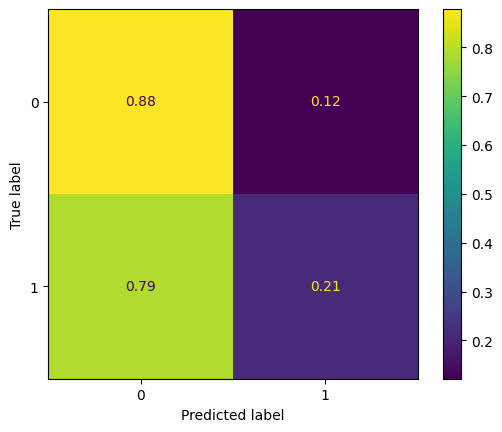

In [90]:
# Calculate precision, recall, and F1 scoreb
report = classification_report(y_test, y_pred)
print(report)

cm = confusion_matrix(y_test, y_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Evaluate based on precision at k

In [102]:
y_test['predicted_proba'] = y_pred_proba
y_test['Date'] = df.loc[y_test.index]['Date']
agg_y_test = y_test.groupby('Date').apply(lambda x: x.nlargest(5, 'predicted_proba')).reset_index(drop=True)
final_agg = agg_y_test.groupby('Date').max('both_legs_profited').reset_index(drop=True)
final_agg.both_legs_profited.mean()

/var/folders/f4/28wskrvx4yz7gqswwx15x1bh0000gn/T/ipykernel_55472/2561858097.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg_y_test = y_test.groupby('Date').apply(lambda x: x.nlargest(5, 'predicted_proba')).reset_index(drop=True)


0.703125

## Logistic Regression

In [ ]:
scaler = StandardScaler().fit(X_train.drop(categorical_features,axis=1))
scaled_X_train = scaler.transform(X_train.drop(categorical_features,axis=1))
scaled_X_val = scaler.transform(X_val.drop(categorical_features,axis=1))
scaled_X_test = scaler.transform(X_test.drop(categorical_features,axis=1))

In [ ]:
y.value_counts()

In [ ]:
clf = LogisticRegression()

# Train the model using the training sets
clf.fit(scaled_X_train, y_train)

# Make predictions using the testing set
lr_preds = clf.predict(scaled_X_test)

lr_pred_proba = clf.predict_proba(scaled_X_test)
lr_pred_proba = np.array([x[1] for x in lr_pred_proba])

In [ ]:
print(f1_score(y_test, lr_preds, average='weighted'))
print(f1_score(y_test, lr_preds, average='micro'))
print(f1_score(y_test, lr_preds, average='macro'))

print(precision_score(y_test, lr_preds))
print(recall_score(y_test, lr_preds))

In [ ]:
np.mean(lr_preds)

## Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, lr_preds, labels=clf.classes_,normalize='true')

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

## Feature Importance

In [ ]:
pi = permutation_importance(clf,scaled_X_test,y_test)

coefs = pd.DataFrame(
    pi['importances_mean'], columns=["Coefficients"], index=X_train.drop(categorical_features,axis=1).columns
)

coefs.plot(kind="barh", figsize=(20, 7))
plt.title("Logistic Regression model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

## GBM

### Optuna

In [ ]:
def objective(trial):
    params = {
        'boosting':'dart',
        "objective": "binary",
#         "metric": "accuracy",
        'class_weight':'balanced',
        "n_estimators": 300,
        "verbosity": -1,
        "bagging_freq": 1,
        'max_bin':trial.suggest_int('max_bin',64,1024),
        'max_depth':trial.suggest_int('max_depth',4,20),

        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 3000),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1000),
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train.drop(categorical_features,axis=1),y_train)
    predictions = model.predict(X_val.drop(categorical_features,axis=1))
    f1 = f1_score(y_val, predictions, average='weighted')
    return -1*f1

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best F1:', study.best_value*(-1))

In [ ]:
hyper_params = study.best_params

In [ ]:
y_train.value_counts()/len(y_train)

In [ ]:
gbm = lgb.LGBMClassifier(**hyper_params)
callbacks = [\
#             lgb.early_stopping(stopping_rounds=10, verbose=1,min_delta=0.001,first_metric_only=False), 
             lgb.log_evaluation(period=1)]

gbm.fit(X_train.drop(categorical_features,axis=1),y_train, 
        eval_set=[(X_val.drop(categorical_features,axis=1), y_val)],
        eval_metric='accuracy',
        callbacks=callbacks,
        feature_name = [f for f in features if f not in categorical_features],
#         categorical_feature=categorical_features
       )

In [ ]:
gbm_preds = gbm.predict(X_test.drop(categorical_features,axis=1))

In [ ]:
print(f1_score(y_test, gbm_preds, average='weighted'))
print(f1_score(y_test, gbm_preds, average='micro'))
print(f1_score(y_test, gbm_preds, average='macro'))

In [ ]:
cm = confusion_matrix(y_test, gbm_preds, labels=gbm.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbm.classes_)
disp.plot()

In [ ]:
importances = gbm.feature_importances_
importances = pd.Series(importances,index=X_train.drop(categorical_features,axis=1).columns).sort_values(ascending=True)

In [ ]:
fig,ax=plt.subplots(figsize=[16,14])
importances.plot.barh(ax=ax)
ax.set_title("Feature Importance by Gain")
fig.tight_layout()

In [ ]:
# STOP

# Regression

## Remove 0s?

In [ ]:
df[df.pnls==0].shape[0]*100.0/df.shape[0]

In [ ]:
df = df[df.pnls!=0]


## X,y split

In [ ]:
features = df.drop(categorical_features+['PNL_IS_0']+\
                   ['abs_spread_normed_max','abs_spread_normed_median',\
                    'abs_spread_normed_75th','abs_spread_normed_90th',\
                    'Date','Ticker_P1','Ticker_P2','SPY_Close_P1','SPY_Close_P2',\
                    'num_entries','pnls']+[c for c in df.columns if '_P1_P1' in c or '_P2_P2' in c],axis=1).columns.tolist()+categorical_features
label = 'pnls'



In [ ]:
X = df[features]
y = df[label]

In [ ]:
# y = pd.Series(np.where(y.abs()<=3.5,0,np.where(y<0,-1,1)))

In [ ]:
# y.value_counts()

## Train test split

In [ ]:
y.abs().describe(np.arange(0,1,0.1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

### Filter Outliers?

In [ ]:
u = np.mean(y_train)
s = np.std(y_train)
y_train = y_train[(y_train>(u-2*s)) & (y_train<(u+2*s))]
X_train = X_train.loc[y_train.index]

In [ ]:
# undersample = RandomUnderSampler(sampling_strategy='not minority')
# X_train, y_train = undersample.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

In [ ]:
y_val.value_counts()

In [ ]:
y_test.value_counts()

## GBM

In [ ]:
# def objective(trial):
#     params = {
#         'boosting':'dart',
#         "objective": "multiclass",
# #         'device':'gpu',
# #         "metric": "accuracy",
# #         'class_weight':'balanced',
#         "n_estimators": 300,
#         "verbosity": -1,
#         "bagging_freq": 1,
#         'max_bin':trial.suggest_int('max_bin',64,1024),
#         'max_depth':trial.suggest_int('max_depth',4,20),

#         "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 3000),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1000),
#     }

#     model = lgb.LGBMClassifier(**params)
#     model.fit(X_train.drop(categorical_features,axis=1),y_train)
#     predictions = model.predict(X_val.drop(categorical_features,axis=1))
#     f1 = f1_score(y_val, predictions, average='weighted')
#     return -1*f1

In [ ]:
def objective(trial):
    params = {
        'boosting':'dart',
        "objective": "mse",
#         'device':'gpu',
        "metric": 'l1',
#         'class_weight':'balanced',
        "n_estimators": 300,
        "verbosity": -1,
#         "bagging_freq": 1,
        'max_bin':trial.suggest_int('max_bin',64,1024),
        'max_depth':trial.suggest_int('max_depth',4,20),

        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 3000),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1000),
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train.drop(categorical_features,axis=1),y_train)
    predictions = model.predict(X_val.drop(categorical_features,axis=1))
    mae = np.mean(abs(predictions-y_val))
    return mae

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

In [ ]:
df[[c for c in features if c not in categorical_features]+[label]].corr()['pnls'].abs().sort_values(ascending=False).head(10)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best mae:', study.best_value)

In [ ]:
hyper_params = study.best_params

In [ ]:
# hyper_params = {
# #     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'mae',
#     'metric': ['l1'],
# #     'eval_metric': ['l1'],
# #     'early_stopping_rounds':10,
#     'learning_rate': 0.2,
# #     'feature_fraction': 0.9,
# #     'bagging_fraction': 0.7,
# #     'bagging_freq': 10,
#     'verbosity': 1,
# #     "max_depth": 8,
# #     "num_leaves": 128,  
# #     "max_bin": 512,
#     "num_iterations": 200,
#     "importance_type":"gain"
    
# #     "silent":False
# }

In [ ]:
gbm = lgb.LGBMRegressor(**hyper_params)
# gbm = lgb.LGBMClassifier(**hyper_params)

callbacks = [\
#             lgb.early_stopping(stopping_rounds=10, verbose=1,min_delta=0.001,first_metric_only=False), 
             lgb.log_evaluation(period=1)]

gbm.fit(X_train.drop(categorical_features,axis=1),y_train, 
        eval_set=[(X_val.drop(categorical_features,axis=1), y_val )],
#         eval_metric='l1',
        callbacks=callbacks,
#         feature_name = features,
#         categorical_feature=categorical_features
       )

In [ ]:
# preds = gbm.predict(X_test.drop(categorical_features,axis=1))
# cm = confusion_matrix(y_test, preds, labels=gbm.classes_,normalize='true')
# cm

In [ ]:
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbm.classes_)
# disp.plot()

### GBM feature importance

In [ ]:
importances = gbm.feature_importances_
importances = pd.Series(importances,index=X_train.drop(categorical_features,axis=1).columns).sort_values(ascending=True)

In [ ]:
fig,ax=plt.subplots(figsize=[16,14])
importances.plot.barh(ax=ax)
ax.set_title("Feature Importance by Gain")
fig.tight_layout()

In [ ]:
pi = permutation_importance(gbm,X_test.drop(categorical_features,axis=1),y_test)

coefs = pd.DataFrame(
    pi['importances_mean'], columns=["Coefficients"], index=X_train.drop(categorical_features,axis=1).columns
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Logistic Regression model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

## Error Analysis

In [ ]:
preds = gbm.predict(X_test.drop(categorical_features,axis=1))

In [ ]:
results = pd.DataFrame({'preds':preds,'true':y_test})
results

In [ ]:
results.describe(np.arange(0,1,0.1))

In [ ]:
mae = (preds-y_test).abs().mean()
mae

In [ ]:
mean_abs_label = y_test.abs().mean()
mean_abs_label

In [ ]:
mae/mean_abs_label

In [ ]:
mae_AR1 = (X_test.PREV_pnls - pnl_not_0.true).abs().mean()
mae_AR1

In [ ]:
mae/mae_AR1

## Linear Regression

In [ ]:
scaler = StandardScaler().fit(X_train.drop(categorical_features,axis=1))
scaled_X_train = scaler.transform(X_train.drop(categorical_features,axis=1))
scaled_X_val = scaler.transform(X_val.drop(categorical_features,axis=1))
scaled_X_test = scaler.transform(X_test.drop(categorical_features,axis=1))

In [ ]:
regr = LinearRegression()

# Train the model using the training sets
regr.fit(scaled_X_train, y_train)

# Make predictions using the testing set
lr_preds = regr.predict(scaled_X_test)

In [ ]:
pi = permutation_importance(regr,scaled_X_test,y_test)

coefs = pd.DataFrame(
    pi['importances_mean'], columns=["Coefficients"], index=X_train.drop(categorical_features,axis=1).columns
)


coefs.plot(kind="barh", figsize=(9, 7))
plt.title("LR model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [ ]:
lr_results = pd.DataFrame({'preds':lr_preds,'true':y_test})
lr_results

In [ ]:
lr_pnl_is_0 = lr_results[lr_results.true==0]
lr_pnl_not_0 = lr_results[lr_results.true!=0]

In [ ]:
mae = (lr_pnl_not_0.preds-lr_pnl_not_0.true).abs().mean()

In [ ]:
mae/mean_abs_label

In [ ]:
# lr_results.loc[tmp_df.index]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(verbose=2,n_jobs=-1)

In [ ]:
rf.fit(X_train.drop(categorical_features,axis=1),y_train)

In [ ]:
preds = rf.predict(X_test.drop(categorical_features,axis=1))

In [ ]:
mae = (preds-y_test).abs().mean()
mae

In [ ]:
mae/mean_abs_label